In [117]:
# Importing necessary libraries

import numpy as np
import pandas as pd 

from scipy.spatial.distance import pdist, jaccard
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
%matplotlib inline

# Question: Which products will an Instacart consumer purchase again?

###### The data already come in good shape -> Let's read and get the first impressions about the data

In [2]:
# Importing the datasets

'''
*files on /data/:

    aisles.csv: List of all aisles
    
    departments.csv: List of all departments 
    
    orders.csv: List off all orders
    
    products: List of all products
    
    order_products__train: Which products were purchased in each order
    
    order_products__prior: Previous order contents from all customers
    
'''

aisles = pd.read_csv('data/aisles.csv')
dep = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
prod = pd.read_csv('data/products.csv')
order_train = pd.read_csv('data/order_products__train.csv')
order_prior = pd.read_csv('data/order_products__prior.csv')

#### First impressions

In [3]:
aisles.head(2)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


    aisle_id: Aisle ID
    aisle: Aisle type

In [4]:
dep.head(2)

,department_id,department
0,1,frozen
1,2,other


    department_id: Department ID 
    department: Department type

In [5]:
orders.sample(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3069682,2379174,185151,prior,12,2,9,5.0
3118233,616489,188014,prior,19,2,11,4.0


    order_id: Order ID

    user_id: User ID

    eval_set: From which set the data came from (prior/train/test/)
    
    order_number: The index of multiple orders (ordered)

    order_dow: Day of the week
    
    order_hour_of_day: Hour of the day

    day_since_prior_order: Days since the last order

In [6]:
len(prod)

49688

In [7]:
prod.head(2)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13


    product_id: Product ID

    product_name: Product Name

    aisle_id: Aisle ID

    department_id: Department ID

In [8]:
order_train.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1


    order_id: Order ID

    product_id: Product ID
    
    add_to_cart_order: The order that products were added into the cart
    
    reordered: Indicates That the customer has a previous order that contains the product

In [9]:
## Getting the train/test/validation sets 
orders.eval_set.unique()

array(['prior', 'train', 'test'], dtype=object)

In [10]:
train_df = orders[(orders.eval_set == 'train') | (orders.eval_set == 'prior')]
#test_df = orders[orders.eval_set == 'test']
#prior_df = orders[orders.eval_set == 'prior']

# Lets use train + prior as train, once that eval_set == test + eval_set == train means the last purchase of our model

#### Purchase frequency per day of the week

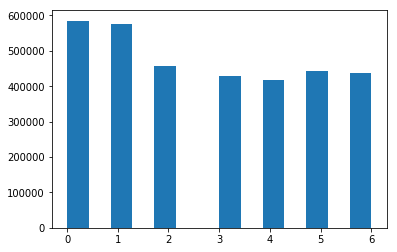

In [11]:
# Checking the frequency per day of week
# 0:SU, 1:MO, 2:TU, 3:WD, 4:TH, 5:FR, 6:ST

hist = plt.hist(train_df.order_dow, bins=14)

#### Purchase frequency by the hour of the day


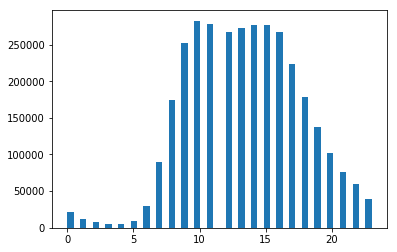

In [12]:
hist = plt.hist(train_df.order_hour_of_day, bins=48)

### Test
### Using Next Basket Prediction using Recurring Sequential Patterns approach

##### Using https://arxiv.org/pdf/1702.07158.pdf let's build a test to see how the method react over our data.

In [13]:
# Spliting into test, train and validation* 

test_df = orders.loc[orders.eval_set == 'test']
train_df = orders.loc[orders.eval_set == 'train']
prior_df = orders.loc[orders.eval_set == 'prior']

In [14]:
bc = dict()

# selecting the customer
customer = prior_df.loc[orders.user_id==1]

# getting all his orders and building a dictonary
for order in customer.order_id:
    if order in bc.keys():
        bc[order].append(order_prior.loc[order_prior.order_id==order].product_id.tolist)
    else:
        bc[order] = order_prior.loc[order_prior.order_id==order].product_id.tolist()

# getting the departments per client
department = []
    
for k,v in bc.items():
    for product in v:
        department.append(int(prod.loc[prod.product_id == product].department_id))

In [15]:
def extractTars(bc):
    S = []
    for k,v in bc.items():
        S.append(v)

(array([  5.,   0.,  13.,   0.,   0.,   0.,   4.,   0.,  15.,  22.]),
 array([  4. ,   5.5,   7. ,   8.5,  10. ,  11.5,  13. ,  14.5,  16. ,
         17.5,  19. ]),
 <a list of 10 Patch objects>)

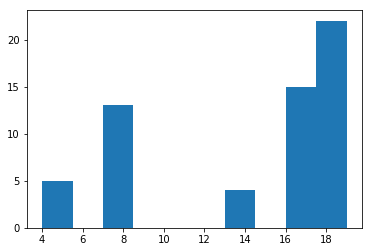

In [16]:
plt.hist(department)

## Recommendation System using a Item base approach, once we have 9 observations per-client. A content-based approach will be used to cluster and classify.

1. Data preparation: Feature selection, D-reduction, Normalizing and Subsetting
2. Data Mining: Clustering (prior) and classification (training)
3. Pos-processing: Filtering and Visualization

#### Data Preparation

In [25]:
# For testing - sampling

prior_df_ = prior_df.iloc[:500,:].copy()
orders_ = orders.iloc[:500,:].copy()

In [75]:
# on the 500 entries dataset, creating a colunm with all the products for that order
product_list = dict()

for order in prior_df_.order_id.unique():
    if order in product_list.keys():
        product_list[order].append(order_prior.loc[order_prior.order_id==order].product_id.tolist)
    else:
        product_list[order] = order_prior.loc[order_prior.order_id==order].product_id.tolist()


# bulding the dummies from the product_list, in order to cluster over Laccart
products = pd.Series(product_list)
prod_dummies = pd.get_dummies(products.apply(pd.Series).stack()).sum(level=0)

In [95]:
# Creating index collunm for dataframe join
prod_dummies['order_id'] = prod_dummies.index

# Join the dummies with the prior orders

jaccard_df = prior_df_.merge(prod_dummies, right_on='order_id', left_on='order_id')

#### Data Mining: User-Item Collaborative Filtering

In [170]:
# running jaccard similarity

res = 1 - pdist(jaccard_df.iloc[:,7:], 'jaccard',)
#res.reshape(500,1740)
distance = pd.DataFrame(squareform(res), index=jaccard_df.user_id,)

In [172]:
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(jaccard_df.iloc[:,7:], metric='jaccard')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, _DataConversionWarning)


In [191]:
len(prod.product_id)

49688

In [186]:
jaccard_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,23.0,34.0,79.0,...,49517.0,49519.0,49533.0,49573.0,49588.0,49615.0,49617.0,49662.0,49680.0,49683.0
0,2539329,1,prior,1,2,8,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2398795,1,prior,2,3,7,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,473747,1,prior,3,3,12,21.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2254736,1,prior,4,4,7,29.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,431534,1,prior,5,4,15,28.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3367565,1,prior,6,2,7,19.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,550135,1,prior,7,1,9,20.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3108588,1,prior,8,1,14,14.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2295261,1,prior,9,1,16,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2550362,1,prior,10,4,8,30.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [180]:
u, s, vt = svds(jaccard_df.iloc[:,7:], k = 20)
s_diag_matrix=np.diag(s)
#X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
#print 'User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))

ValueError: matrix type must be 'f', 'd', 'F', or 'D'

#### Post processing

In [ ]:
knn.fit(prior_df_.loc[:,'product'], prior_df_.loc[:,'user_id'])

In [ ]:
prior_df_.loc[:,'product'].tolist()